# 1 CNNs en CIFAR10

### (a) Preparación de subconjuntos (batches) de entrenamiento.

Importación de datos desde dataset.

In [1]:
import numpy as np
import os
import pickle

def load_CIFAR_batch(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='latin1')
        X = datadict['data']
        Y = np.array(datadict['labels'])
        f.close()
        return X, Y

def load_CIFAR10(PATH):
    xs = []
    ys = []
    Xva = np.array([])
    Yva = np.array([])
    for b in range(1,6):
        f = os.path.join(PATH, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        if b == 5:
            Xva = X[-5000:]
            X = X[:-5000]
            Yva = Y[-5000:]
            Y = Y[:-5000]
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(PATH, 'test_batch'))
    return Xtr, Ytr, Xva, Yva, Xte, Yte

#cargado de dataset (ubicado en directorio /data/)
Xtr, Ytr, Xva, Yva, Xte, Yte = load_CIFAR10('data')

Nombrado de las etiquetas:

In [2]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',\
               'dog', 'frog', 'horse', 'ship', 'truck']


Normalización y re-shaping:

In [3]:
import keras

Xtr = Xtr.reshape((Xtr.shape[0],32,32,3))/255
Xva = Xva.reshape((Xva.shape[0],32,32,3))/255
Xte = Xte.reshape((Xte.shape[0],32,32,3))/255
Ytr = keras.utils.to_categorical(Ytr, 10)
Yva = keras.utils.to_categorical(Yva, 10)
Yte = keras.utils.to_categorical(Yte, 10)

Using TensorFlow backend.


### (b) Definición CNN de arquitectura C x P x C x P x F x F con las especificaciones indicadas.

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D

model = Sequential()
model.add(Convolution2D(64, 3, 3, border_mode='same', input_shape=Xtr.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

c:\program files\python35\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", input_shape=(32, 32, 3...)`
  
c:\program files\python35\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
  if __name__ == '__main__':


De forma esquemática, la red queda:

In [19]:
# Ejecutar este bloque si se usa Windows
import os
os.environ['PATH'] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [64]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='data/model1.png', show_shapes=True)

<img src="data/ann_tarea2_modelo1.png">

### (c) Entrenamiento de la CNN. Primero se define un step decay para mejorar el entrenamiento.

In [8]:
from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler
import math

def step_decay(epoch):
    initial_rate = 0.001
    lrate = initial_rate*math.pow(0.5, math.floor((1+epoch)/5))
    lrate = max(lrate, 0.00001)
    return lrate

Luego, se configura el entrenamiento del modelo.

In [9]:
opt = SGD(lr=0.0, momentum =0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)

from keras.callbacks import Callback

class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y, results = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        results['test_loss'].append(loss)
        results['test_acc'].append(acc)
        print('\ntest_loss: {}, test_acc: {}\n'.format(loss, acc))

model.compile(optimizer=opt,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

Finalmente, se entrena.

In [11]:
import tensorflow as tf
conf = tf.ConfigProto()
conf.gpu_options.allow_growth = True
sess = tf.Session(config=conf)

from keras import backend as k
k.set_session(sess)

results_test = {'test_loss': [], 'test_acc': []}

results=model.fit(Xtr, Ytr, batch_size=32, epochs=25,
         validation_data=(Xva, Yva), callbacks=[lrate, TestCallback((Xte, Yte, results_test))],
          shuffle=True)


Train on 45000 samples, validate on 5000 samples
Epoch 1/25
44960/45000 [============================>.] - ETA: 0s - loss: 1.9586 - acc: 0.3011
test_loss: 1.6701937688827515, test_acc: 0.4006

45000/45000 [==============================] - 20s - loss: 1.9584 - acc: 0.3012 - val_loss: 1.6796 - val_acc: 0.3980
Epoch 2/25
44960/45000 [============================>.] - ETA: 0s - loss: 1.5855 - acc: 0.4395
test_loss: 1.4889769971847535, test_acc: 0.4716

45000/45000 [==============================] - 16s - loss: 1.5855 - acc: 0.4396 - val_loss: 1.4831 - val_acc: 0.4712
Epoch 3/25
44992/45000 [============================>.] - ETA: 0s - loss: 1.4517 - acc: 0.4893
test_loss: 1.392905816268921, test_acc: 0.5045

45000/45000 [==============================] - 17s - loss: 1.4517 - acc: 0.4893 - val_loss: 1.3852 - val_acc: 0.5082
Epoch 4/25
44928/45000 [============================>.] - ETA: 0s - loss: 1.3614 - acc: 0.5220
test_loss: 1.3409812454223633, test_acc: 0.5268

45000/45000 [============

AttributeError: Can't pickle local object 'strided_slice.<locals>.assign'

In [13]:
results.history

{'acc': [0.30115555555555557,
  0.43955555555555553,
  0.48926666666666668,
  0.52206666666666668,
  0.55604444444444445,
  0.57173333333333332,
  0.58471111111111107,
  0.59655555555555551,
  0.60824444444444448,
  0.62768888888888885,
  0.6332888888888889,
  0.64133333333333331,
  0.6429555555555555,
  0.65108888888888894,
  0.66515555555555561,
  0.66775555555555555,
  0.67177777777777781,
  0.67297777777777779,
  0.6763555555555556,
  0.68275555555555556,
  0.68400000000000005,
  0.68608888888888886,
  0.68926666666666669,
  0.68982222222222223,
  0.69420000000000004],
 'loss': [1.9583820443471274,
  1.5854776343663533,
  1.4517133716795179,
  1.3611263168758816,
  1.2709205879635281,
  1.230112361462911,
  1.1940058340920343,
  1.1589807370079888,
  1.127717461766137,
  1.0753368627124362,
  1.0591872263378568,
  1.0423729936175876,
  1.0260272937562731,
  1.0115829060872397,
  0.97998388517167834,
  0.97078147142198346,
  0.96197230050828719,
  0.95399760225084096,
  0.9461297978

In [12]:
results_test

{'test_acc': [0.40060000000000001,
  0.47160000000000002,
  0.50449999999999995,
  0.52680000000000005,
  0.54220000000000002,
  0.57050000000000001,
  0.58230000000000004,
  0.5726,
  0.5887,
  0.60189999999999999,
  0.60440000000000005,
  0.60170000000000001,
  0.59389999999999998,
  0.61560000000000004,
  0.61929999999999996,
  0.62419999999999998,
  0.62029999999999996,
  0.62549999999999994,
  0.62519999999999998,
  0.63060000000000005,
  0.62749999999999995,
  0.63249999999999995,
  0.62990000000000002,
  0.62649999999999995,
  0.63239999999999996],
 'test_loss': [1.6701937688827515,
  1.4889769971847535,
  1.392905816268921,
  1.3409812454223633,
  1.2877969844818116,
  1.2335977832794189,
  1.2105818077087402,
  1.2153853956222533,
  1.1692911220550537,
  1.1425153560638428,
  1.1309814840316772,
  1.1360276264190674,
  1.1459664449691773,
  1.1035540143013001,
  1.0978341176986695,
  1.0841636300086974,
  1.0860864337921143,
  1.0810888918876649,
  1.0770873615264893,
  1.0658

### (d) Entrenamiento de la CNN, ahora usando RMSProp. Función de pérdida: categorical_crossentropy

Primero, se redefinen las propiedades de la CNN:

In [48]:
from keras.optimizers import rmsprop

opt = rmsprop(lr=0.001, decay=1e-6)

from keras.callbacks import Callback

class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y, results = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        results['test_loss'].append(loss)
        results['test_acc'].append(acc)
        print('\ntest_loss: {}, test_acc: {}\n'.format(loss, acc))

model.compile(optimizer=opt,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

Finalmente, se entrena.

In [49]:
# Se debe redifinir el modelo CNN para reiniciar la sesión de TensorFlowy poder usar la GPU
import tensorflow as tf
conf = tf.ConfigProto()
conf.gpu_options.allow_growth = True
sess = tf.Session(config=conf)

from keras import backend as k
k.set_session(sess)

results2_test = {'test_loss': [], 'test_acc': []}

results2=model.fit(Xtr, Ytr, batch_size=32, epochs=25,
         validation_data=(Xva, Yva), callbacks=[lrate, TestCallback((Xte, Yte, results2_test))],
          shuffle=True)


Train on 45000 samples, validate on 5000 samples
Epoch 1/25
44928/45000 [============================>.] - ETA: 0s - loss: 6.7085 - acc: 0.2515
test_loss: 1.6502731342315673, test_acc: 0.4101

45000/45000 [==============================] - 20s - loss: 6.7005 - acc: 0.2517 - val_loss: 1.6377 - val_acc: 0.4074
Epoch 2/25
44928/45000 [============================>.] - ETA: 0s - loss: 1.5256 - acc: 0.4634
test_loss: 1.5547240097045898, test_acc: 0.4446

45000/45000 [==============================] - 20s - loss: 1.5253 - acc: 0.4634 - val_loss: 1.5526 - val_acc: 0.4486
Epoch 3/25
44960/45000 [============================>.] - ETA: 0s - loss: 1.4448 - acc: 0.4961
test_loss: 1.5452886821746825, test_acc: 0.4604

45000/45000 [==============================] - 19s - loss: 1.4449 - acc: 0.4959 - val_loss: 1.5435 - val_acc: 0.4614
Epoch 4/25
44992/45000 [============================>.] - ETA: 0s - loss: 1.4306 - acc: 0.5030
test_loss: 1.4674077739715576, test_acc: 0.5022

45000/45000 [===========

In [19]:
results2.history

{'acc': [0.4635111111111111,
  0.59517777777777781,
  0.65362222222222222,
  0.69973333333333332,
  0.7805333333333333,
  0.81337777777777776,
  0.84148888888888884,
  0.8690444444444444,
  0.89311111111111108,
  0.94240000000000002,
  0.95668888888888892,
  0.96757777777777776,
  0.97593333333333332,
  0.98237777777777779,
  0.99368888888888884,
  0.99562222222222219,
  0.99717777777777783,
  0.99822222222222223,
  0.9986666666666667,
  0.99948888888888887,
  0.99957777777777779,
  0.99957777777777779,
  0.99964444444444445,
  0.99975555555555551,
  0.99982222222222217],
 'loss': [1.5190647723939683,
  1.1577257038964166,
  0.99673778947194414,
  0.87158326119316953,
  0.63722311316596136,
  0.543614936070972,
  0.46519396800200147,
  0.38762916230360667,
  0.32045991039276123,
  0.19012634454965591,
  0.14956965385145612,
  0.11888875090082486,
  0.093722564345598225,
  0.073254618414656983,
  0.038359603670405015,
  0.0295417659205695,
  0.022962624534012543,
  0.01767330014647709,


In [20]:
results2_test

{'test_acc': [0.50519999999999998,
  0.57830000000000004,
  0.58289999999999997,
  0.61419999999999997,
  0.6603,
  0.65620000000000001,
  0.65010000000000001,
  0.64790000000000003,
  0.65669999999999995,
  0.67889999999999995,
  0.66779999999999995,
  0.6774,
  0.66239999999999999,
  0.67249999999999999,
  0.67149999999999999,
  0.67510000000000003,
  0.67390000000000005,
  0.67300000000000004,
  0.67759999999999998,
  0.67749999999999999,
  0.67649999999999999,
  0.6744,
  0.67689999999999995,
  0.6764,
  0.67469999999999997],
 'test_loss': [1.4071819358825683,
  1.2054073863983155,
  1.1681012150764465,
  1.1383170220375061,
  1.0468562387466431,
  1.1353889781951905,
  1.2368360993385314,
  1.1949283189773559,
  1.4356832663536072,
  1.4049488978385924,
  1.5428268049240113,
  1.6231901470184327,
  1.6197902615547179,
  1.8029204758644104,
  1.8051546380996704,
  1.9788989573478699,
  1.9395004014968873,
  2.0734431687355039,
  2.2128501656532289,
  2.2186824129104616,
  2.2423140

Evolución de la CNN con SGD y RMSProp:

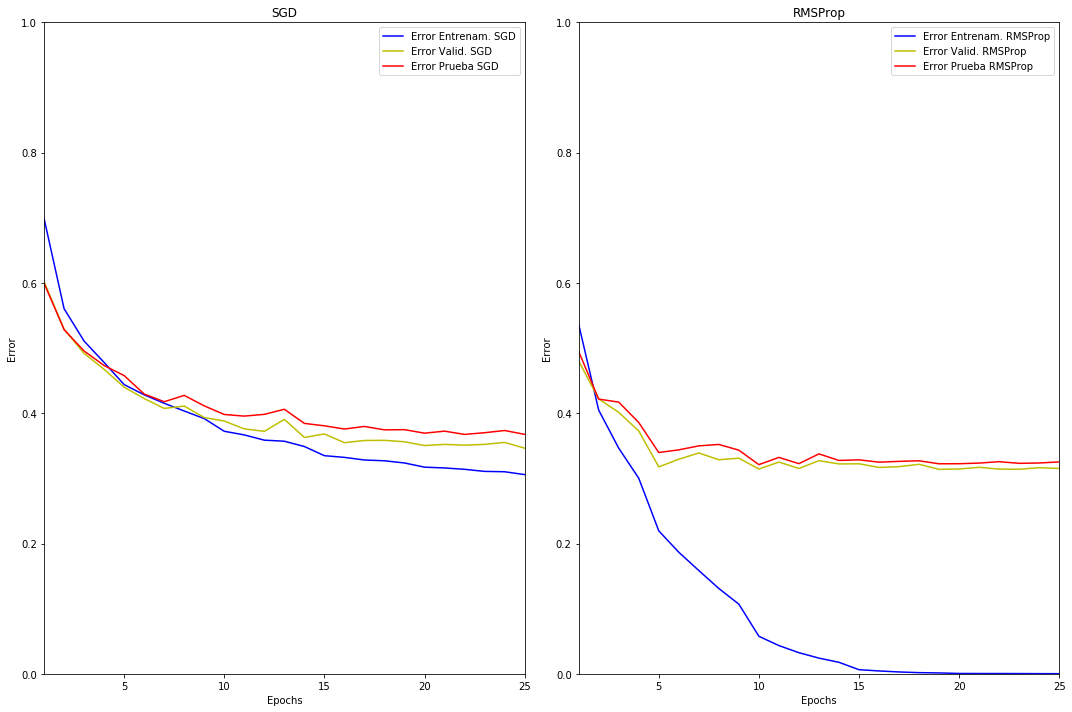

In [39]:
import matplotlib.pyplot as plt

# Error = 1 - Accuracy
train_error_sgd = 1 - np.array(results.history['acc'])
validation_error_sgd = 1 - np.array(results.history['val_acc'])
test_error_sgd = 1 - np.array(results_test['test_acc'])
train_error_rmsprop = 1 - np.array(results2.history['acc'])
validation_error_rmsprop = 1 - np.array(results2.history['val_acc'])
test_error_rmsprop = 1 - np.array(results2_test['test_acc'])

plt.subplots(1,2,figsize=(15,10))
plt.subplot(1, 2, 1)
plt.plot(range(1,len(train_error_sgd)+1), train_error_sgd, 'b', label='Error Entrenam. SGD')
plt.plot(range(1,len(train_error_sgd)+1), validation_error_sgd, 'y', label='Error Valid. SGD')
plt.plot(range(1,len(train_error_sgd)+1), test_error_sgd, 'r', label='Error Prueba SGD')
plt.title('SGD')
plt.ylabel('Error')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.axis([1,25,0.0,1.0])

plt.subplot(1, 2, 2)
#plt.gcf().clear()
plt.plot(range(1,len(train_error_rmsprop)+1), train_error_rmsprop, 'b', label='Error Entrenam. RMSProp')
plt.plot(range(1,len(train_error_rmsprop)+1), validation_error_rmsprop, 'y', label='Error Valid. RMSProp')
plt.plot(range(1,len(train_error_rmsprop)+1), test_error_rmsprop, 'r', label='Error Prueba RMSProp')
plt.title('RMSProp')
plt.ylabel('Error')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.axis([1,25,0.0,1.0])

plt.tight_layout()
plt.show()



Tiempo de ejecución (promedio) de SGD: 17 [s/epoch] (425 [s] total)

Tiempo de ejecución (promedio) de RMSProp: 19 [s/epoch] (475 [s] total)



(e) Diseño de una CNN de arquitectura CxCxPxCxCxPxFxF.

Primero, se prueba una arquitectura, cuyos filtros en las capas convolucionales 
mantienen su tamaño original de 3x3.

In [51]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D

model = Sequential()
model.add(Convolution2D(64, 3, 3, border_mode='same', input_shape=Xtr.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_79 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
activation_80 (Activation)   (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 8, 8, 64)          0         
__________

c:\program files\python35\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  
c:\program files\python35\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
  if __name__ == '__main__':
c:\program files\python35\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
  del sys.path[0]
c:\program files\python35\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
  app.launch_new_instance()


Se entrenará durante 25 epochs usando SGD con tasa de aprendizaje descendente (comprobada como menos propensa a overfitting en el ítem anterior).

In [52]:
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
import math

opt = SGD(lr=0.01, momentum=0.9, decay=0.0001)

from keras.callbacks import Callback

class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y, results = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        results['test_loss'].append(loss)
        results['test_acc'].append(acc)
        print('\ntest_loss: {}, test_acc: {}\n'.format(loss, acc))

model.compile(optimizer=opt,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

Entrenamiento CNN de filtros fijos de 3x3:

In [53]:
import tensorflow as tf
conf = tf.ConfigProto()
conf.gpu_options.allow_growth = True
sess = tf.Session(config=conf)

from keras import backend as k
k.set_session(sess)

results_3x3_3x3_test = {'test_loss': [], 'test_acc': []}

results_3x3_3x3=model.fit(Xtr, Ytr, batch_size=32, epochs=25,
         validation_data=(Xva, Yva), callbacks=[TestCallback((Xte, Yte, results_3x3_3x3_test))],
          shuffle=True)


Train on 45000 samples, validate on 5000 samples
Epoch 1/25
44928/45000 [============================>.] - ETA: 0s - loss: 1.8901 - acc: 0.2951
test_loss: 1.5896450023651123, test_acc: 0.4178

45000/45000 [==============================] - 23s - loss: 1.8898 - acc: 0.2951 - val_loss: 1.5856 - val_acc: 0.4034
Epoch 2/25
44864/45000 [============================>.] - ETA: 0s - loss: 1.5651 - acc: 0.4286
test_loss: 1.4114604312896728, test_acc: 0.4854

45000/45000 [==============================] - 19s - loss: 1.5648 - acc: 0.4286 - val_loss: 1.4196 - val_acc: 0.4748
Epoch 3/25
44896/45000 [============================>.] - ETA: 0s - loss: 1.4286 - acc: 0.4867
test_loss: 1.3065099380493164, test_acc: 0.5266

45000/45000 [==============================] - 19s - loss: 1.4287 - acc: 0.4865 - val_loss: 1.2951 - val_acc: 0.5250
Epoch 4/25
44992/45000 [============================>.] - ETA: 0s - loss: 1.3303 - acc: 0.5243
test_loss: 1.239840036392212, test_acc: 0.5522

45000/45000 [============

In [56]:
results_3x3_3x3.history

{'acc': [0.29513333333333336,
  0.42862222222222224,
  0.48653333333333332,
  0.52431111111111106,
  0.5494,
  0.57479999999999998,
  0.59622222222222221,
  0.61104444444444439,
  0.62891111111111109,
  0.64182222222222218,
  0.65620000000000001,
  0.66317777777777775,
  0.67442222222222226,
  0.68400000000000005,
  0.69415555555555553,
  0.70153333333333334,
  0.70853333333333335,
  0.71640000000000004,
  0.72257777777777776,
  0.72915555555555556,
  0.73611111111111116,
  0.74084444444444442,
  0.74695555555555559,
  0.75375555555555551,
  0.75864444444444445],
 'loss': [1.8897895254347059,
  1.5648314649793837,
  1.4287400114059448,
  1.3303354865180121,
  1.2578037490208944,
  1.1860438172446357,
  1.1323082126617432,
  1.0884276368247139,
  1.0406244569990371,
  1.0049978716320462,
  0.96935220296647817,
  0.94083390383190579,
  0.91390653776592679,
  0.88438578245374888,
  0.85783110437393184,
  0.83763531541824343,
  0.81120452341503568,
  0.79242384103139241,
  0.77290193888346

In [57]:
results_3x3_3x3_test

{'test_acc': [0.4178,
  0.4854,
  0.52659999999999996,
  0.55220000000000002,
  0.54979999999999996,
  0.59970000000000001,
  0.60209999999999997,
  0.60770000000000002,
  0.63139999999999996,
  0.64039999999999997,
  0.63800000000000001,
  0.64349999999999996,
  0.64070000000000005,
  0.65200000000000002,
  0.63929999999999998,
  0.65620000000000001,
  0.64319999999999999,
  0.65920000000000001,
  0.66039999999999999,
  0.66669999999999996,
  0.6613,
  0.66080000000000005,
  0.6593,
  0.67030000000000001,
  0.67320000000000002],
 'test_loss': [1.5896450023651123,
  1.4114604312896728,
  1.3065099380493164,
  1.239840036392212,
  1.2692825138092041,
  1.1254188302993775,
  1.1311207914352417,
  1.1039226032257079,
  1.0485861317634582,
  1.0248176349639893,
  1.0351688488960267,
  1.0238430568695069,
  1.0129896419525146,
  1.00122195520401,
  1.040723731994629,
  0.99101822547912599,
  1.0331043157577515,
  1.0040533925056458,
  0.99964552850723265,
  0.97829374322891238,
  0.99268230

Tiempo de ejecución: 19 [s/epoch] (total: 475 [s]) 

Redefinición de la CNN: Primera capa convolucional con filtros de tamaño 3x3; segunda con filtros de 5x5.

In [54]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D

model = Sequential()
model.add(Convolution2D(64, 3, 3, border_mode='same', input_shape=Xtr.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, 5, 5, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(128, 5, 5, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
import math

opt = SGD(lr=0.01, momentum=0.9, decay=0.0001)

from keras.callbacks import Callback

class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y, results = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        results['test_loss'].append(loss)
        results['test_acc'].append(acc)
        print('\ntest_loss: {}, test_acc: {}\n'.format(loss, acc))

model.compile(optimizer=opt,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

import tensorflow as tf
conf = tf.ConfigProto()
conf.gpu_options.allow_growth = True
sess = tf.Session(config=conf)

from keras import backend as k
k.set_session(sess)

results_3x3_5x5_test = {'test_loss': [], 'test_acc': []}

results_3x3_5x5=model.fit(Xtr, Ytr, batch_size=32, epochs=25,
         validation_data=(Xva, Yva), callbacks=[TestCallback((Xte, Yte, results_3x3_5x5_test))],
          shuffle=True)

c:\program files\python35\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  
c:\program files\python35\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), padding="same")`
  if __name__ == '__main__':
c:\program files\python35\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
  del sys.path[0]
c:\program files\python35\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 5), padding="same")`
  app.launch_new_instance()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_85 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 16, 16, 64)        102464    
_________________________________________________________________
activation_86 (Activation)   (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 8, 8, 64)          0         
__________

In [58]:
results_3x3_5x5.history

{'acc': [0.29975555555555555,
  0.4400222222222222,
  0.4967111111111111,
  0.53900000000000003,
  0.56588888888888889,
  0.58837777777777778,
  0.61353333333333337,
  0.63053333333333328,
  0.64964444444444447,
  0.66442222222222225,
  0.67648888888888892,
  0.68857777777777773,
  0.70028888888888885,
  0.71328888888888886,
  0.72255555555555551,
  0.73353333333333337,
  0.74382222222222227,
  0.75319999999999998,
  0.75742222222222222,
  0.76828888888888891,
  0.77717777777777775,
  0.78211111111111109,
  0.79055555555555557,
  0.79508888888888885,
  0.80637777777777775],
 'loss': [1.8777857929653592,
  1.5366155342949761,
  1.3982634687635633,
  1.2936557238260904,
  1.2141190088060168,
  1.1498168354988099,
  1.0856671141094631,
  1.0405803007973564,
  0.98941302152209809,
  0.9454397581948174,
  0.90840504031711156,
  0.87444023914602065,
  0.84337234808603923,
  0.80280730991363525,
  0.77237045015758943,
  0.74572570146984529,
  0.71698927152951564,
  0.68818621210522124,
  0.67

In [59]:
results_3x3_5x5_test

{'test_acc': [0.38769999999999999,
  0.496,
  0.51180000000000003,
  0.52700000000000002,
  0.57469999999999999,
  0.58299999999999996,
  0.60389999999999999,
  0.61229999999999996,
  0.62009999999999998,
  0.63200000000000001,
  0.63949999999999996,
  0.63360000000000005,
  0.64329999999999998,
  0.64700000000000002,
  0.65359999999999996,
  0.6431,
  0.65600000000000003,
  0.6573,
  0.65820000000000001,
  0.65769999999999995,
  0.65939999999999999,
  0.65359999999999996,
  0.66349999999999998,
  0.66500000000000004,
  0.66279999999999994],
 'test_loss': [1.6476300506591797,
  1.3880371046066284,
  1.3591463542938231,
  1.3079079059600831,
  1.1832146947860718,
  1.1819405988693237,
  1.1269887029647827,
  1.1033340364456177,
  1.0859670644760131,
  1.0467573480606078,
  1.0311985925674438,
  1.0587903898239135,
  1.0495143801689149,
  1.0263342845916748,
  1.0294626966476441,
  1.0516607155799866,
  1.0350983464241028,
  1.0348694602966308,
  1.0421315473556518,
  1.0754845390319825,

Tiempo de ejecución: 24 [s/epoch] (total: 600 [s]) 

Redefinición de la CNN: Primera capa convolucional con filtros de tamaño 5x5; segunda con filtros de 3x3.

In [55]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D

model = Sequential()
model.add(Convolution2D(64, 5, 5, border_mode='same', input_shape=Xtr.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Convolution2D(128, 5, 5, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
import math

opt = SGD(lr=0.01, momentum=0.9, decay=0.0001)

from keras.callbacks import Callback

class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y, results = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        results['test_loss'].append(loss)
        results['test_acc'].append(acc)
        print('\ntest_loss: {}, test_acc: {}\n'.format(loss, acc))

model.compile(optimizer=opt,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

import tensorflow as tf
conf = tf.ConfigProto()
conf.gpu_options.allow_growth = True
sess = tf.Session(config=conf)

from keras import backend as k
k.set_session(sess)

results_5x5_3x3_test = {'test_loss': [], 'test_acc': []}

results_5x5_3x3=model.fit(Xtr, Ytr, batch_size=32, epochs=25,
         validation_data=(Xva, Yva), callbacks=[TestCallback((Xte, Yte, results_5x5_3x3_test))],
          shuffle=True)

c:\program files\python35\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), input_shape=(32, 32, 3..., padding="same")`
  
c:\program files\python35\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
  if __name__ == '__main__':
c:\program files\python35\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 5), padding="same")`
  del sys.path[0]
c:\program files\python35\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
  app.launch_new_instance()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 32, 32, 64)        4864      
_________________________________________________________________
activation_91 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
activation_92 (Activation)   (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 8, 8, 64)          0         
__________

In [43]:
results_5x5_3x3.history

{'acc': [0.28546666666666665,
  0.42057777777777777,
  0.4781111111111111,
  0.5106222222222222,
  0.54617777777777776,
  0.57462222222222226,
  0.59462222222222227,
  0.61739999999999995,
  0.63202222222222226,
  0.64842222222222223,
  0.69868888888888891,
  0.71535555555555552,
  0.72748888888888885,
  0.73604444444444439,
  0.74464444444444444,
  0.75611111111111107,
  0.76564444444444446,
  0.77275555555555553,
  0.77897777777777777,
  0.78908888888888884,
  0.82640000000000002,
  0.83955555555555561,
  0.84324444444444446,
  0.85026666666666662,
  0.85737777777777779],
 'loss': [1.9267485447353787,
  1.5827150957107543,
  1.4436295386420357,
  1.3481943560070462,
  1.2643732848061455,
  1.1908854983859591,
  1.1329558865441216,
  1.0734407911088732,
  1.0310997070736356,
  0.98641913294262351,
  0.84560050370958117,
  0.7989171479331123,
  0.76669767306645709,
  0.73809038086997136,
  0.70649465998543637,
  0.67736256411870321,
  0.65547823352283907,
  0.6307551417880588,
  0.6089

In [60]:
results_5x5_3x3_test

{'test_acc': [0.3891,
  0.45760000000000001,
  0.49740000000000001,
  0.53590000000000004,
  0.56159999999999999,
  0.5575,
  0.58330000000000004,
  0.59819999999999995,
  0.60219999999999996,
  0.6048,
  0.60780000000000001,
  0.61839999999999995,
  0.62280000000000002,
  0.61809999999999998,
  0.63229999999999997,
  0.6361,
  0.63239999999999996,
  0.63180000000000003,
  0.63680000000000003,
  0.63370000000000004,
  0.63680000000000003,
  0.63660000000000005,
  0.63200000000000001,
  0.63780000000000003,
  0.64119999999999999],
 'test_loss': [1.6369843273162841,
  1.4843902601242065,
  1.384204752922058,
  1.2933913513183595,
  1.2348115550041199,
  1.2386949846267701,
  1.1789418142318726,
  1.1526376384735106,
  1.1348255856513978,
  1.1162838167190552,
  1.1081513078689575,
  1.0752070029258729,
  1.1007979703903199,
  1.1049646084785461,
  1.0827660949707032,
  1.0735818711280822,
  1.0986978265762328,
  1.1318810571670532,
  1.0958036215782165,
  1.1070540868759156,
  1.11837770

Tiempo de ejecución: 21 [s/epoch] (total: 525 [s]) 

Comparación gráfica de los tres resultados:

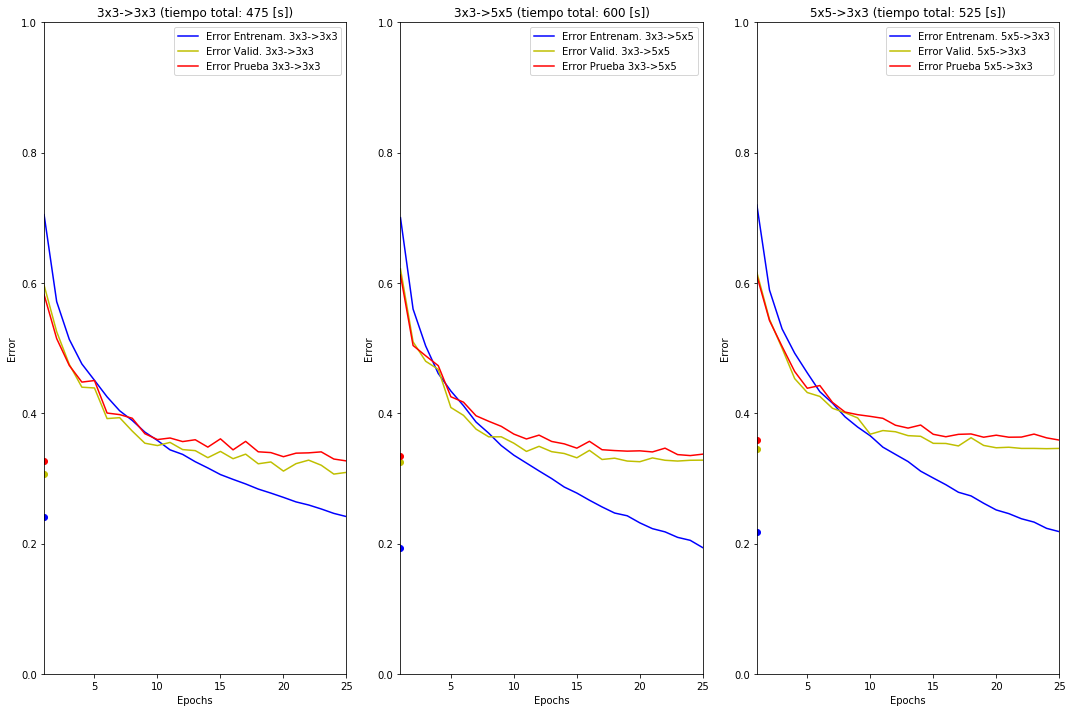

In [73]:
import matplotlib.pyplot as plt

# Error = 1 - Accuracy
# 3x3->3x3
train_error_3x3_3x3 = 1 - np.array(results_3x3_3x3.history['acc'])
validation_error_3x3_3x3 = 1 - np.array(results_3x3_3x3.history['val_acc'])
test_error_3x3_3x3 = 1 - np.array(results_3x3_3x3_test['test_acc'])

# 3x3->5x5
train_error_3x3_5x5 = 1 - np.array(results_3x3_5x5.history['acc'])
validation_error_3x3_5x5 = 1 - np.array(results_3x3_5x5.history['val_acc'])
test_error_3x3_5x5 = 1 - np.array(results_3x3_5x5_test['test_acc'])

# 5x5->3x3
train_error_5x5_3x3 = 1 - np.array(results_5x5_3x3.history['acc'])
validation_error_5x5_3x3 = 1 - np.array(results_5x5_3x3.history['val_acc'])
test_error_5x5_3x3 = 1 - np.array(results_5x5_3x3_test['test_acc'])

plt.subplots(1,3,figsize=(15,10))
plt.subplot(1, 3, 1)
plt.plot(range(1,len(train_error_3x3_3x3)+1), train_error_3x3_3x3, 'b', label='Error Entrenam. 3x3->3x3')
plt.plot([1], [min(train_error_3x3_3x3)], 'bo')
plt.plot(range(1,len(train_error_3x3_3x3)+1), validation_error_3x3_3x3, 'y', label='Error Valid. 3x3->3x3')
plt.plot([1], [min(validation_error_3x3_3x3)], 'yo')
plt.plot(range(1,len(train_error_3x3_3x3)+1), test_error_3x3_3x3, 'r', label='Error Prueba 3x3->3x3')
plt.plot([1], [min(test_error_3x3_3x3)], 'ro')
plt.title('3x3->3x3 (tiempo total: 475 [s])')
plt.ylabel('Error')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.axis([1,25,0.0,1.0])

plt.subplot(1, 3, 2)
plt.plot(range(1,len(train_error_3x3_5x5)+1), train_error_3x3_5x5, 'b', label='Error Entrenam. 3x3->5x5')
plt.plot([1], [min(train_error_3x3_5x5)], 'bo')
plt.plot(range(1,len(train_error_3x3_5x5)+1), validation_error_3x3_5x5, 'y', label='Error Valid. 3x3->5x5')
plt.plot([1], [min(validation_error_3x3_5x5)], 'yo')
plt.plot(range(1,len(train_error_3x3_5x5)+1), test_error_3x3_5x5, 'r', label='Error Prueba 3x3->5x5')
plt.plot([1], [min(test_error_3x3_5x5)], 'ro')
plt.title('3x3->5x5 (tiempo total: 600 [s])')
plt.ylabel('Error')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.axis([1,25,0.0,1.0])

plt.subplot(1, 3, 3)
plt.plot(range(1,len(train_error_5x5_3x3)+1), train_error_5x5_3x3, 'b', label='Error Entrenam. 5x5->3x3')
plt.plot([1], [min(train_error_5x5_3x3)], 'bo')
plt.plot(range(1,len(train_error_5x5_3x3)+1), validation_error_5x5_3x3, 'y', label='Error Valid. 5x5->3x3')
plt.plot([1], [min(validation_error_5x5_3x3)], 'yo')
plt.plot(range(1,len(train_error_5x5_3x3)+1), test_error_5x5_3x3, 'r', label='Error Prueba 5x5->3x3')
plt.plot([1], [min(test_error_5x5_3x3)], 'ro')
plt.title('5x5->3x3 (tiempo total: 525 [s])')
plt.ylabel('Error')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.axis([1,25,0.0,1.0])

plt.tight_layout()
plt.show()



De lo obtenido, se concluye que variar el tamaño de los filtros no es útil, al menos cuando el resto de los parámetros, tales como tasa de aprendizaje, momentum, decay, y dropout, se mantienen igual. La variación del tamaño de filtros, además, implica mayores tiempos de ejecución y una tendencia mayor al overfitting.

Sin embargo, con esto no se descarta por completo su utilidad. Es posible que, con el ajuste correcto de parámetros, se logre mejorar el resultado respecto al uso de filtros de tamaño fijo, aunque con esto no lograría disminuir el tiempo de entrenamiento.

Comparando los resultados de las redes de filtros de tamaño varaible, se nota que aquella que pasa de filtros pequeños a grandes se comporta ligeramente mejor que aquella que los empequeñece, aunque toma más tiempo de entrenamiento.

Finalmente, se concluye que lo más sensato es mantener el tamaño de los filtros utilizados, cuando se usan capas de pooling. La justificación es que esto permite la detección de patrones (características) de forma local por parte de los filtros, los cuales, al pasarse por un pooling, permiten a los filtros siguientes examinar y descubrir características más generales, dado que se ha reducido la dimensionalidad de la entrada. O sea, el tamaño de la imagen disminuye, pero no el del filtro, por lo tanto, el filtro captura una porción más grande de la misma.

## (f) Reemplazo de capas de pooling por capas convolucionales de stride 2.

In [77]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D

model = Sequential()
model.add(Convolution2D(128, 3, 3, border_mode='same', input_shape=Xtr.shape[1:]))
model.add(Activation('relu'))
model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3, subsample=(2, 2), border_mode='valid'))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3, subsample=(2, 2), border_mode='valid'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
import math

opt = SGD(lr=0.01, momentum=0.9, decay=0.0001)

from keras.callbacks import Callback

class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y, results = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        results['test_loss'].append(loss)
        results['test_acc'].append(acc)
        print('\ntest_loss: {}, test_acc: {}\n'.format(loss, acc))

model.compile(optimizer=opt,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

import tensorflow as tf
conf = tf.ConfigProto()
conf.gpu_options.allow_growth = True
sess = tf.Session(config=conf)

from keras import backend as k
k.set_session(sess)

results_conv_only_test = {'test_loss': [], 'test_acc': []}

results_conv_only=model.fit(Xtr, Ytr, batch_size=32, epochs=25,
         validation_data=(Xva, Yva), callbacks=[TestCallback((Xte, Yte, results_conv_only_test))],
          shuffle=True)

c:\program files\python35\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  
c:\program files\python35\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
  
c:\program files\python35\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="valid", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
c:\program files\python35\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
  del sys.path[0]
c:\program files\python35\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
  app.launch_new_instance()
c:\program files\p

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_83 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
activation_118 (Activation)  (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
activation_119 (Activation)  (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 15, 15, 64)        73792     
_________________________________________________________________
activation_120 (Activation)  (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 15, 15, 64)        0         
__________

Tiempo de ejecución: 57 [s/epoch] (total: 1425 [s]) 

In [78]:
results_conv_only.history

{'acc': [0.32315555555555553,
  0.45604444444444442,
  0.5145777777777778,
  0.55453333333333332,
  0.58855555555555561,
  0.61528888888888889,
  0.64513333333333334,
  0.66375555555555554,
  0.68726666666666669,
  0.70333333333333337,
  0.7251333333333333,
  0.74351111111111112,
  0.75504444444444441,
  0.77022222222222225,
  0.7847777777777778,
  0.79548888888888891,
  0.80908888888888886,
  0.81840000000000002,
  0.82802222222222222,
  0.83946666666666669,
  0.84728888888888887,
  0.85431111111111113,
  0.86662222222222218,
  0.8726666666666667,
  0.87771111111111111],
 'loss': [1.8533971976386177,
  1.5059228605482313,
  1.3564857853783501,
  1.2483207331763373,
  1.1566403653886583,
  1.0764133546617296,
  1.0085190520445506,
  0.94097959901359352,
  0.87901207959916861,
  0.82463544674979317,
  0.77281989731258816,
  0.72301162391238738,
  0.67954367733001708,
  0.63646563677257961,
  0.60043877540164525,
  0.5659441524399651,
  0.53067206329239736,
  0.50061372584236996,
  0.475

In [81]:
results_conv_only_test['test_acc'] = [0.4395,
                                      0.5054,
                                      0.5427,
                                      0.5717,
                                      0.6025,
                                      0.6157,
                                      0.6284,
                                      0.6404,
                                      0.6344,
                                      0.6424,
                                      0.6509,
                                      0.6548,
                                      0.6571,
                                      0.6589,
                                      0.6546,
                                      0.6614,
                                      0.6588,
                                      0.6472,
                                      0.653,
                                      0.6607,
                                      0.6551,
                                      0.648,
                                      0.6553,
                                      0.6553,
                                      0.6593
                                      ]

Evolución del error versus el número de epochs:

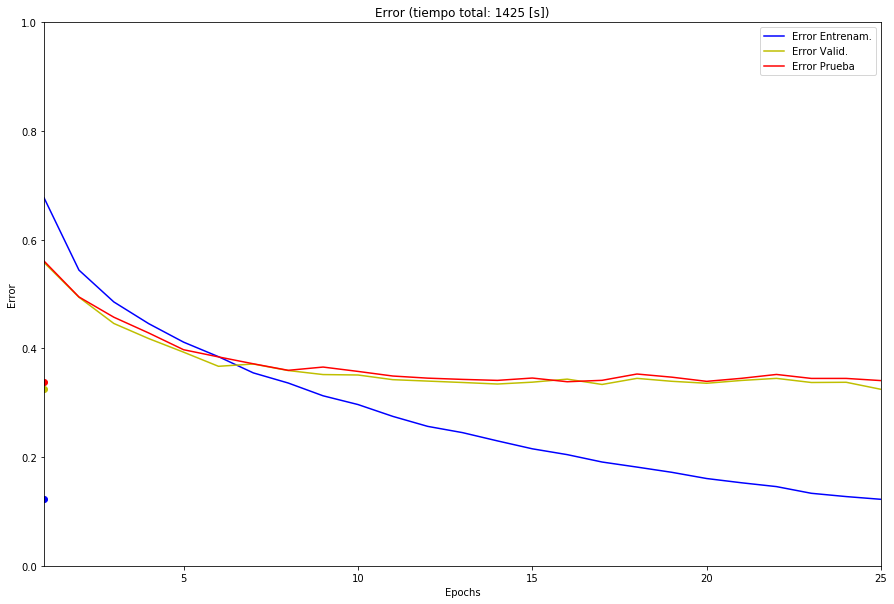

In [85]:
import matplotlib.pyplot as plt

# Error = 1 - Accuracy
train_error_conv_only = 1 - np.array(results_conv_only.history['acc'])
validation_error_conv_only = 1 - np.array(results_conv_only.history['val_acc'])
test_error_conv_only = 1 - np.array(results_conv_only_test['test_acc'])

plt.gcf().clear()
plt.subplots(1,1,figsize=(15,10))
plt.subplot(1, 1, 1)
plt.plot(range(1,len(train_error_conv_only)+1), train_error_conv_only, 'b', label='Error Entrenam.')
plt.plot([1], [min(train_error_conv_only)], 'bo')
plt.plot(range(1,len(train_error_conv_only)+1), validation_error_conv_only, 'y', label='Error Valid.')
plt.plot([1], [min(validation_error_conv_only)], 'yo')
plt.plot(range(1,len(train_error_conv_only)+1), test_error_conv_only, 'r', label='Error Prueba')
plt.plot([1], [min(test_error_conv_only)], 'ro')
plt.title('Error (tiempo total: 1425 [s])')
plt.ylabel('Error')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.axis([1,25,0.0,1.0])

plt.show()

## (g) Aplicación de transformaciones a conjunto de entrenamiento

In [5]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    rotation_range=0, # randomly rotate images (degrees, 0 to 180)
    width_shift_range=0.1, # randomly shift images horizontally (fraction of width)
    height_shift_range=0.1, # randomly shift images vertically (fraction of height)
    horizontal_flip=True, # randomly flip images
    vertical_flip=False) # randomly flip images

datagen.fit(Xtr)

# Definicion del modelo
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D

model = Sequential()
model.add(Convolution2D(128, 3, 3, border_mode='same', input_shape=Xtr.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
#model.add(Dropout(0.25))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

from keras.optimizers import SGD
from keras.callbacks import Callback
import math

opt = SGD(lr=0.025, momentum=0.9, decay=0.0005)

class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y, results = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        results['test_loss'].append(loss)
        results['test_acc'].append(acc)
        print('\ntest_loss: {}, test_acc: {}\n'.format(loss, acc))

model.compile(optimizer=opt,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

import tensorflow as tf
conf = tf.ConfigProto()
conf.gpu_options.allow_growth = True
sess = tf.Session(config=conf)

from keras import backend as k
k.set_session(sess)

results_datagen_test = {'test_loss': [], 'test_acc': []}

results_datagen=model.fit_generator(datagen.flow(Xtr, Ytr, batch_size=100),
                                       steps_per_epoch=Xtr.shape[0]//100,
                                       epochs=30, validation_data=(Xte, Yte)) 


c:\program files\python35\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), input_shape=(32, 32, 3..., padding="same")`
c:\program files\python35\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
c:\program files\python35\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
c:\program files\python35\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
activation_8 (Activation)    (None, 16, 16, 128)       0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 64)          73792     
__________

In [6]:
results_datagen.history

{'acc': [0.25959999173879622,
  0.37111109842856727,
  0.42695554117361706,
  0.45986665255493586,
  0.48817775905132293,
  0.50922220091025039,
  0.53622220026122203,
  0.54859997709592179,
  0.5649777572022544,
  0.57513331029150216,
  0.58639998111459946,
  0.59508887026045054,
  0.60186664640903476,
  0.60826664805412289,
  0.61546664410167273,
  0.62302220099502137,
  0.62928886711597443,
  0.63386664695209927,
  0.64057775530550209,
  0.64931108911832169,
  0.64864442394839394,
  0.65239997625350954,
  0.65953331298298301,
  0.66242219938172231,
  0.66453331258561876,
  0.66906664424472384,
  0.67155553513103061,
  0.67266664425532019,
  0.67426664630571997,
  0.68117775705125594],
 'loss': [1.9806664853625828,
  1.7032282837231953,
  1.5686904276741875,
  1.4792913987901475,
  1.4133985553847419,
  1.3568569416469998,
  1.2938907027244568,
  1.2555443635251786,
  1.2159612815909915,
  1.1850647530290817,
  1.1616848091284433,
  1.1312407737308079,
  1.1125473426447974,
  1.09312

In [7]:
results_datagen_2=model.fit_generator(datagen.flow(Xtr, Ytr, batch_size=100),
                                       steps_per_epoch=Xtr.shape[0]//100,
                                       epochs=30, validation_data=(Xte, Yte))

Epoch 1/30
450/450 [==============================] - 19s - loss: 0.8920 - acc: 0.6832 - val_loss: 0.9664 - val_acc: 0.6604
Epoch 2/30
450/450 [==============================] - 19s - loss: 0.8845 - acc: 0.6858 - val_loss: 0.9526 - val_acc: 0.6721
Epoch 3/30
450/450 [==============================] - 19s - loss: 0.8792 - acc: 0.6868 - val_loss: 1.0002 - val_acc: 0.6474
Epoch 4/30
450/450 [==============================] - 19s - loss: 0.8698 - acc: 0.6896 - val_loss: 0.9582 - val_acc: 0.6651
Epoch 5/30
450/450 [==============================] - 19s - loss: 0.8679 - acc: 0.6925 - val_loss: 0.9609 - val_acc: 0.6674
Epoch 6/30
450/450 [==============================] - 19s - loss: 0.8594 - acc: 0.6927 - val_loss: 0.9521 - val_acc: 0.6693
Epoch 7/30
450/450 [==============================] - 19s - loss: 0.8474 - acc: 0.6963 - val_loss: 0.9436 - val_acc: 0.6682
Epoch 8/30
450/450 [==============================] - 19s - loss: 0.8441 - acc: 0.6990 - val_loss: 0.9337 - val_acc: 0.6730
Epoch 9/

Tiempo de entrenamiento: 19 [s/epoch] (tiempo total: 2·30·19 = 1140 [s])

Evolución del modelo:

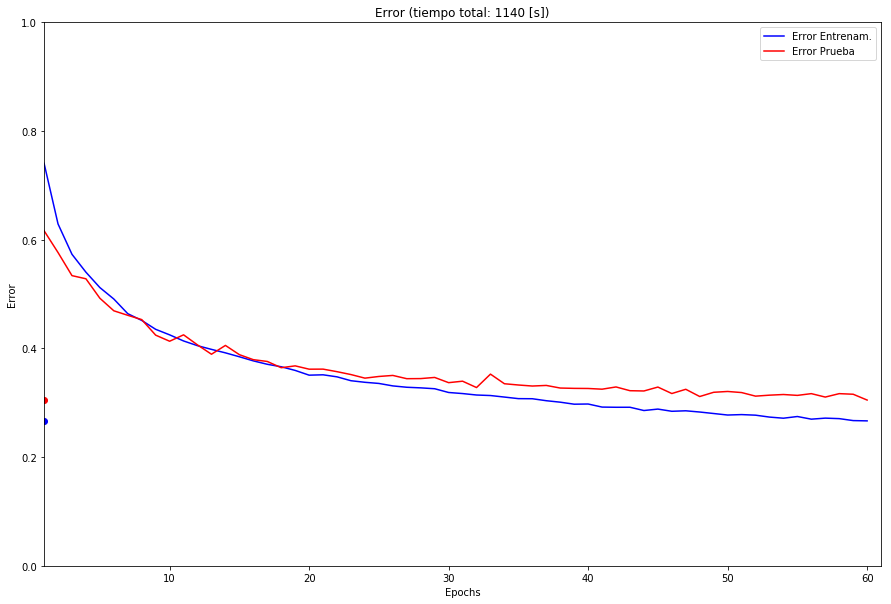

In [8]:
import matplotlib.pyplot as plt

# Error = 1 - Accuracy
train_error_datagen = np.array([results_datagen.history['acc'], results_datagen_2.history['acc']])
train_error_datagen = 1 - np.concatenate(train_error_datagen)
test_error_datagen = np.array([results_datagen.history['val_acc'], results_datagen_2.history['val_acc']])
test_error_datagen = 1 - np.concatenate(test_error_datagen)

plt.gcf().clear()
plt.subplots(1,1,figsize=(15,10))
plt.subplot(1, 1, 1)
plt.plot(range(1,len(train_error_datagen)+1), train_error_datagen, 'b', label='Error Entrenam.')
plt.plot([1], [min(train_error_datagen)], 'bo')
plt.plot(range(1,len(train_error_datagen)+1), test_error_datagen, 'r', label='Error Prueba')
plt.plot([1], [min(test_error_datagen)], 'ro')
plt.title('Error (tiempo total: 1140 [s])')
plt.ylabel('Error')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.axis([1,len(train_error_datagen)+1,0.0,1.0])

plt.show()

En efecto, aplicar transformaciones a las imágenes de entrenamiento permite que el modelo evite sobreajustarse, precisamente por el hecho de que el conjunto de pruebas ya no es fijo. Si bien no se logró disminuir el error más allá de 0.3, se confirma que el comportamiento del modelo durante su entrenamiento es mucho más predecible. La correcta elección de hiperparámetros (cantidad de capas y filtros, su tamaño, learning rate, decay, etc.), aprovechando el efecto de regularización del ImageDataGenerator, permitirían que el modelo converja a un nivel de error menor al observado.

## (h) Detección de objetos confundibles

Para cada clase, se extraen sus imagenes y se almacenan en distintas variables.

In [9]:
cifar_airplanes = []
cifar_automobiles = []
cifar_birds = []
cifar_cats = []
cifar_deers = []
cifar_dogs = []
cifar_frogs = []
cifar_horses = []
cifar_ships = []
cifar_trucks = []
cifar_all = [cifar_airplanes,
            cifar_automobiles,
            cifar_birds,
            cifar_cats,
            cifar_deers,
            cifar_dogs,
            cifar_frogs,
            cifar_horses,
            cifar_ships,
            cifar_trucks]

i = 0
for image in Xte:
    cifar_all[Yte[i].argmax()].append(image)
    i+=1

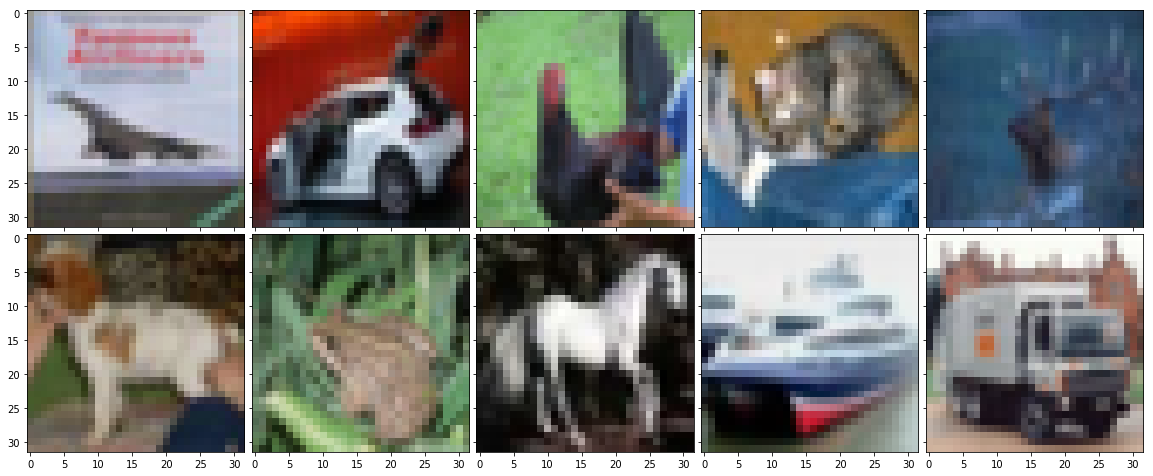

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(1, (20.,10.))
grid = ImageGrid(fig, 111,
                nrows_ncols=(2,5),
                axes_pad=0.1
                )

grid[0].imshow(cifar_airplanes[0].reshape(3,32,32).transpose(1,2,0))
grid[1].imshow(cifar_automobiles[0].reshape(3,32,32).transpose(1,2,0))
grid[2].imshow(cifar_birds[0].reshape(3,32,32).transpose(1,2,0))
grid[3].imshow(cifar_cats[0].reshape(3,32,32).transpose(1,2,0))
grid[4].imshow(cifar_deers[0].reshape(3,32,32).transpose(1,2,0))
grid[5].imshow(cifar_dogs[0].reshape(3,32,32).transpose(1,2,0))
grid[6].imshow(cifar_frogs[0].reshape(3,32,32).transpose(1,2,0))
grid[7].imshow(cifar_horses[0].reshape(3,32,32).transpose(1,2,0))
grid[8].imshow(cifar_ships[0].reshape(3,32,32).transpose(1,2,0))
grid[9].imshow(cifar_trucks[0].reshape(3,32,32).transpose(1,2,0))

plt.show()

Se usará el último modelo entrenado (ítem g).

In [11]:
airplane_results=model.predict(np.array(cifar_airplanes))
automobile_results=model.predict(np.array(cifar_automobiles))
bird_results=model.predict(np.array(cifar_birds))
cat_results=model.predict(np.array(cifar_cats))
deer_results=model.predict(np.array(cifar_deers))
dog_results=model.predict(np.array(cifar_dogs))
frog_results=model.predict(np.array(cifar_frogs))
horse_results=model.predict(np.array(cifar_horses))
ship_results=model.predict(np.array(cifar_ships))
truck_results=model.predict(np.array(cifar_trucks))

Cuantización de predicciones (distrib. Probabilidad -> número de clase)

In [12]:
q_airplane_results = [np.array(m).argmax() for m in airplane_results]
q_automobile_results = [np.array(m).argmax() for m in automobile_results]
q_bird_results = [np.array(m).argmax() for m in bird_results]
q_cat_results = [np.array(m).argmax() for m in cat_results]
q_deer_results = [np.array(m).argmax() for m in deer_results]
q_dog_results = [np.array(m).argmax() for m in dog_results]
q_frog_results = [np.array(m).argmax() for m in frog_results]
q_horse_results = [np.array(m).argmax() for m in horse_results]
q_ship_results = [np.array(m).argmax() for m in ship_results]
q_truck_results = [np.array(m).argmax() for m in truck_results]

Histogramas de las predicciones

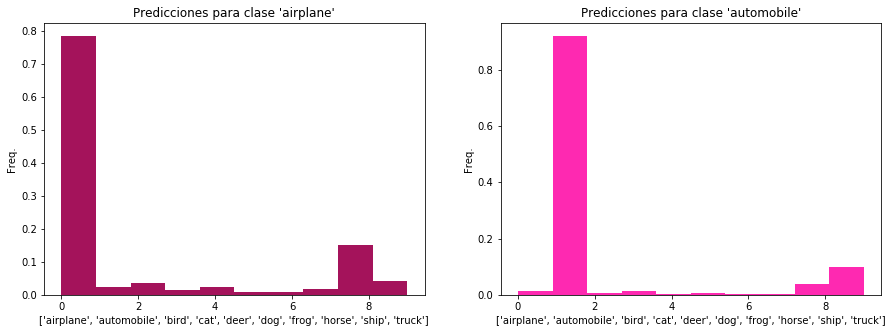

In [13]:
import matplotlib.pyplot as plt

plt.gcf().clear()
plt.subplots(1,2,figsize=(15,5))

plt.subplot(1, 2, 1)
plt.hist(q_airplane_results, normed=True, color=np.random.rand(3,))
plt.title('Predicciones para clase \'airplane\'')
plt.ylabel('Freq.')
plt.xlabel(label_names)

plt.subplot(1, 2, 2)
plt.hist(q_automobile_results, normed=True, color=np.random.rand(3,))
plt.title('Predicciones para clase \'automobile\'')
plt.ylabel('Freq.')
plt.xlabel(label_names)

plt.show()

Lo que se aprecia en los histogramas es la predicción hecha por la CNN para imágenes que corresponden a una misma clase.
De un conjunto de entradas de clase 'airplane', La CNN sabe decidir casi 0.8 de los casos la clase correcta. Pero con probabilidad 0.15 aproximadamente, tiende a clasificar incorrectamente como 'ship' o barco. Con el histograma de la derecha, la entrada corresponde a imágenes de automóviles. se nota que el modelo CNN decide correctamente con probabilidad 0.9, y que existe una chance de un poco menos de 0.1 de que se confunda y clasifique como 'truck' o camión. 

Ambos casos de confusión se pueden entender intituivamente: ambos aviones y barcos, al ser vehículos que se desplazan en fluidos, tienen una forma aero/hidrodinámica, que define una estructura similar a grandes rasgos: parte delantera puntiaguda, y un cuerpo o armazón lisos y alargados. Para el caso de confusión entre autos y camiones ocurre lo mismo: ambos vehículos poseen ruedas y una estructura que tiende a ser prismática rectangular. Estas características (óvalos para las ruedas, puntas, líneas rectas, etc.) activan kernels en común dentro de la red convolucional, aumentando la probabilidad de generar salidas incorrectas.

Puede apreciarse el mismo fenómeno en las demás predicciones.

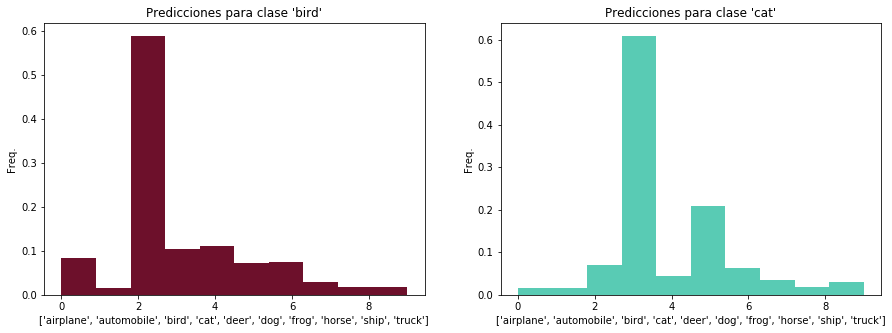

In [14]:
import matplotlib.pyplot as plt

plt.gcf().clear()
plt.subplots(1,2,figsize=(15,5))

plt.subplot(1, 2, 1)
plt.hist(q_bird_results, normed=True, color=np.random.rand(3,))
plt.title('Predicciones para clase \'bird\'')
plt.ylabel('Freq.')
plt.xlabel(label_names)

plt.subplot(1, 2, 2)
plt.hist(q_cat_results, normed=True, color=np.random.rand(3,))
plt.title('Predicciones para clase \'cat\'')
plt.ylabel('Freq.')
plt.xlabel(label_names)

plt.show()

En particular, la clase 'bird' o pájaro, junto a 'cat' o gato, resultan ser las que peor confiabilidad de predicción tienen. El modelo logra clasificar un pájaro correctamente con probabilidad 0.6, mientras que el resto de las veces, aproximadamente, tenderá a elegir 'airplane', 'car', 'deer', 'dog' o 'frog'. De todas estas posibles opciones incorrectas, que tienen probabilidad ~0.1, 'deer' resulta ser, por poco, la clase con la que más se confunda la red cuando recibe pájaros de input.

De igual forma, la capacidad de predicción para gatos es pobre en comparación a las demas clases. en un ~0.6 de los casos, la CNN elige correctamente, y con un ~0.2 de probabilidad elige incorrectamente 'dog'. La confusión, como se explicó, se debe a características en común entre las clases. Sin embargo, queda por conjeturar una razón para el pobre rendimiento de predicción.

Una razón puede ser las muchas razas que existen de estos animales, que los hacen variar tanto en tamaño como en forma (pelaje, en caso de los gatos), por lo que, para efectos de entrenamiento, son necesarios más ejemplos de estas dos clases para lograr mejorar y equiparar la calidad de predicción con el de las demás.

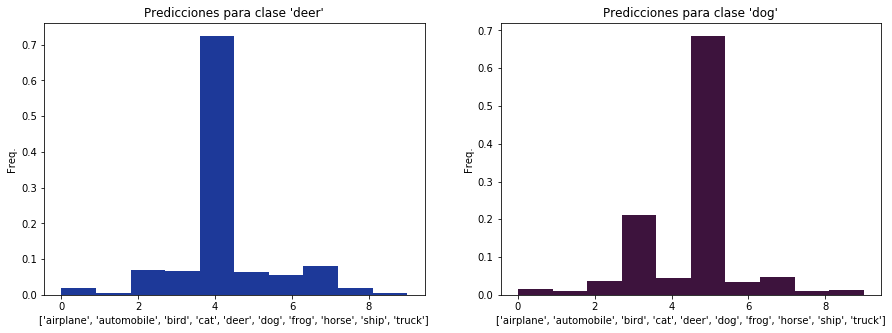

In [15]:
import matplotlib.pyplot as plt

plt.gcf().clear()
plt.subplots(1,2,figsize=(15,5))

plt.subplot(1, 2, 1)
plt.hist(q_deer_results, normed=True, color=np.random.rand(3,))
plt.title('Predicciones para clase \'deer\'')
plt.ylabel('Freq.')
plt.xlabel(label_names)

plt.subplot(1, 2, 2)
plt.hist(q_dog_results, normed=True, color=np.random.rand(3,))
plt.title('Predicciones para clase \'dog\'')
plt.ylabel('Freq.')
plt.xlabel(label_names)

plt.show()

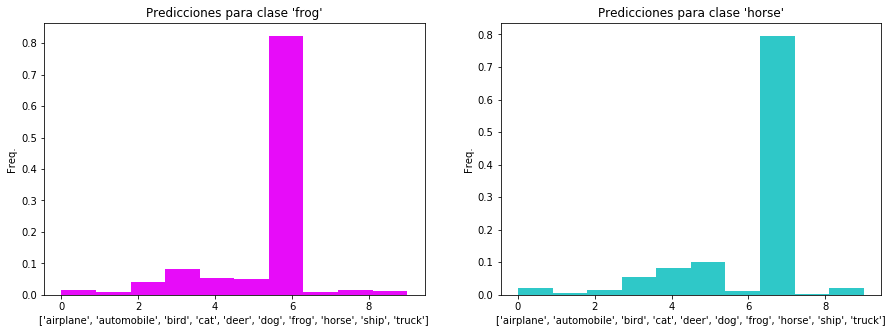

In [16]:
import matplotlib.pyplot as plt

plt.gcf().clear()
plt.subplots(1,2,figsize=(15,5))

plt.subplot(1, 2, 1)
plt.hist(q_frog_results, normed=True, color=np.random.rand(3,))
plt.title('Predicciones para clase \'frog\'')
plt.ylabel('Freq.')
plt.xlabel(label_names)

plt.subplot(1, 2, 2)
plt.hist(q_horse_results, normed=True, color=np.random.rand(3,))
plt.title('Predicciones para clase \'horse\'')
plt.ylabel('Freq.')
plt.xlabel(label_names)

plt.show()

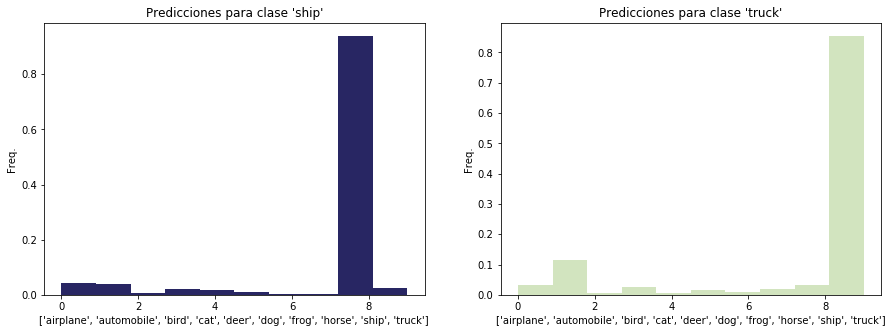

In [17]:
import matplotlib.pyplot as plt

plt.gcf().clear()
plt.subplots(1,2,figsize=(15,5))

plt.subplot(1, 2, 1)
plt.hist(q_ship_results, normed=True, color=np.random.rand(3,))
plt.title('Predicciones para clase \'ship\'')
plt.ylabel('Freq.')
plt.xlabel(label_names)

plt.subplot(1, 2, 2)
plt.hist(q_truck_results, normed=True, color=np.random.rand(3,))
plt.title('Predicciones para clase \'truck\'')
plt.ylabel('Freq.')
plt.xlabel(label_names)

plt.show()